In [1]:
!nvidia-smi

Sat Apr 29 17:52:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
| 57%   51C    P2              149W / 390W|    993MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# (1) Import the required libraries

In [67]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re 

# (2) Download the datasets

### You can download the dataset from https://www.kaggle.com/datasets/nulldata/medium-post-titles.

# (3) Prepare the datasets

In [5]:
datasets = pd.read_csv("./datasets/medium_post_titles.csv")

In [6]:
datasets.head(3)

,category,title,subtitle,subtitle_truncated_flag
0,work,"""21 Conversations"" - A fun (and easy) game for...",A (new?) Icebreaker game to get your team to s...,False
1,spirituality,"""Biblical Porn"" at Mars Hill",Author and UW lecturer Jessica Johnson talks a...,False
2,lgbtqia,"""CISGENDER?! Is That A Disease?!""","Or, a primer in gender vocabulary for the curi...",False


### Since the objective of this project is to predict the next word, I will solely concentrate on utilizing the title. This is usually the case when conducting a Google search and suggestions for related searches appear, which is the inspiration for this project.

In [7]:
datasets_title = datasets.title

In [8]:
datasets_title.head(3)

0    "21 Conversations" - A fun (and easy) game for...
1                         "Biblical Porn" at Mars Hill
2                    "CISGENDER?! Is That A Disease?!"
Name: title, dtype: object

# (4) Perform data preprocessing

### The Tokenizer will, by default, generate an id for each word and convert them to lowercase.






I aim to include the beginning and end of each sentence before tokenizing them. This way, we can use this information to stop text generation appropriately.

In [9]:
datasets_title_modified = datasets_title.apply(lambda x: "sevendi " + x + " poluan")

I also intend to perform data cleaning using regex in this case.

In [10]:
datasets_title_modified = datasets_title_modified.map(lambda x: ' ' . join(re.findall(r"[a-zA-Z]+", x)).lower())

In [11]:
datasets_title_modified[0]

'sevendi conversations a fun and easy game for teams to get to know each other poluan'

In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>")

In [13]:
tokenizer.fit_on_texts(datasets_title_modified)

Show some sample results

In [14]:
tokenizer.texts_to_sequences([datasets_title_modified[5]])

[[2, 23493, 8, 711, 808, 4, 323, 1076, 569, 1565, 3]]

In [15]:
tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([datasets_title_modified[5]]))

['sevendi cypherpunks and wall street the security token revolution regulation poluan']

### We can sort all the words based on their frequencies

In [16]:
sorted_vocab = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)

In [17]:
sorted_vocab[2:12] # word with most frequencies

[('the', 48206),
 ('to', 28115),
 ('a', 25614),
 ('of', 22701),
 ('and', 17984),
 ('in', 15510),
 ('s', 14857),
 ('how', 12786),
 ('is', 11945),
 ('for', 11126)]

In [18]:
sorted_vocab[-10:] #  word with least frequencies

[('herakitty', 1),
 ('snowplay', 1),
 ('kcleaner', 1),
 ('instagrammable', 1),
 ('kongers', 1),
 ('emitters', 1),
 ('foundries', 1),
 ('commandos', 1),
 ('amersfoort', 1),
 ('utrecht', 1)]

In [19]:
TOTAL_VOCABULARY = int(len(sorted_vocab))
TOTAL_VOCABULARY

42889

### Display a wordcloud to visualize the overall text frequency of each word in the dataset.

In [20]:
word_to_dict = dict(sorted_vocab[2:])

In [21]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10) # .generate(datasets_title)
wordcloud.fit_words(word_to_dict)

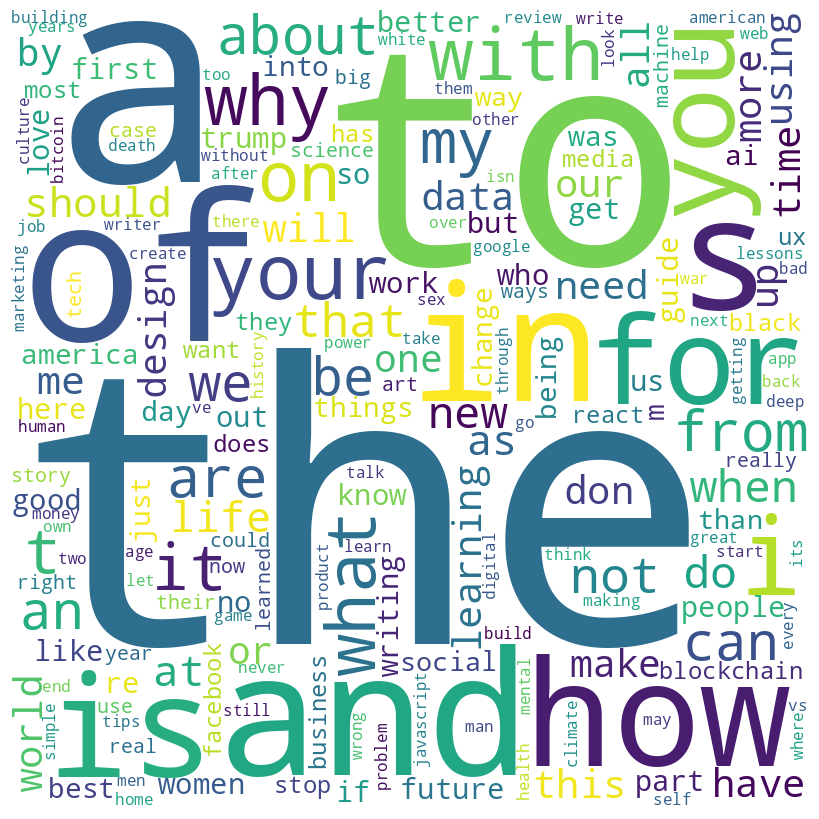

In [22]:
# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Although the most frequently occurring words are typically stop words in a sentence, this is acceptable since our aim is to build a model for predicting the next words.

### The data will be tokenized to prepare for training and testing. Multi-grams will be used to build the dataset in this case.

In [23]:
def n_gramize(data):
    n = 2
    sequences = []
    for x in data:
        to_sequence = np.squeeze(tokenizer.texts_to_sequences([x]))

        # multi-grams
        for y in range(len(to_sequence), n, -1):
            sequences.append(to_sequence[0:y])

        # n-grams
        # for i in range(n, len(to_sequence) + 1):
        #    seq = to_sequence[i-n:i]
        #    sequences.append(seq)
    return sequences

In [24]:
TOTAL_DATA = int(len(datasets_title_modified) * .2)

In [25]:
train_ds = n_gramize(datasets_title_modified.values[:-TOTAL_DATA])
test_ds = n_gramize(datasets_title_modified.values[-TOTAL_DATA:])

In [26]:
train_ds[:20]

[array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5,   72, 1119,  194,    3]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5,   72, 1119,  194]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5,   72, 1119]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5,   72]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13]),
 array([   2, 1790,    6,  762,    8,  405,  153]),
 array([   2, 1790,    6,  762,    8,  405]),
 array([   2, 1790,    6,  762,    8]),
 array([   2, 1790,    6,  762]),
 array([   2, 1790,    6]),
 array([   2, 7576, 15

### How long is the longest sequence in our available data? We need to know this in order to prepare for padding.

In [27]:
max_length = max([max([len(seq) for seq in train_ds]), max([len(seq) for seq in test_ds])])

In [28]:
max_length

25

In [29]:
train_with_padding = tf.keras.preprocessing.sequence.pad_sequences(train_ds, maxlen=max_length, padding='pre')
test_with_padding = tf.keras.preprocessing.sequence.pad_sequences(test_ds, maxlen=max_length, padding='pre')

By doing this, we can make sure that all sequences are of the same length. If a sequence is shorter than 20, it will be padded with zeros until it reaches the desired length.

In [30]:
train_with_padding[3]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,
         69,    5,   72], dtype=int32)

# (5) Let's build our training data now.

In [31]:
def func(sequence_data):
    attention_mask = tf.cast(tf.not_equal(sequence_data[:-1], 0), tf.int32)
    # one_hot = tf.one_hot(sequence_data[-1], TOTAL_VOCABULARY, axis=0) # cost memory
    return sequence_data[:-1], sequence_data[-1]

In [32]:
train_tf = tf.data.Dataset.from_tensor_slices(train_with_padding)
test_tf = tf.data.Dataset.from_tensor_slices(test_with_padding)

2023-04-29 19:52:20.388625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [33]:
BATCH_SIZE = 32

In [34]:
train = train_tf.map(func).cache().prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000).batch(BATCH_SIZE)
test = test_tf.map(func).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

# (6) Construct a basic model






In [35]:
def create_model():
     
    embedding = tf.keras.layers.Embedding(input_dim=TOTAL_VOCABULARY, output_dim=1024, input_length=max_length, name="embedding")
    
    inputs = tf.keras.layers.Input(shape=(max_length - 1,), name="inputs") # minus 1 because the last index has been made as a label
    
    x = embedding(inputs)  
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=False))(x)  
    x = tf.keras.layers.Dense(2048, activation="relu")(x)  
    outputs = tf.keras.layers.Dense(TOTAL_VOCABULARY, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(lr=0.00001),
                  metrics=["accuracy"])
    model.summary()
    return model

# (7) Train our model

In [36]:
model = create_model()

2023-04-29 19:52:30.352603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 19:52:30.354053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 19:52:30.354998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 1024)          43918336  
                                                                 
 bidirectional (Bidirectiona  (None, 2048)             16785408  
 l)                                                              
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 42889)             87879561  
                                                                 
Total params: 152,779,657
Trainable params: 152,779,657
Non-trainable params: 0
_______________________________________________

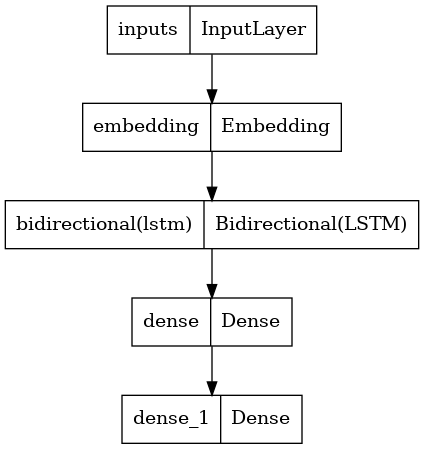

In [37]:
tf.keras.utils.plot_model(model)

In [38]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience="7", start_from_epoch=0)

In [39]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None):
        
        print('\rlogs: ', logs, '\r')
        
        current_val_loss = 0 if logs['val_loss'] is None else logs['val_loss']
        
        print('\rcurrent_val_loss: ', current_val_loss, '\r')
        print('\rsave_best_only: ', self.save_best_only, '\r')
        print('\rbest_val_loss: ', self.best_val_loss, '\r')
        print('\rcurrent_val_loss < best_val_loss: ', current_val_loss < self.best_val_loss, '\r') 
        
        if self.save_best_only and current_val_loss < self.best_val_loss:
            print('\rSaving weights at (save_best_only=True): ', self.model_path, '\r')
            self.best_val_loss = current_val_loss 
            self.model.save_weights(self.model_path)
            print("\rModel has been saved!")
        else:
            print('\rSaving weights at (save_best_only=False): ', self.model_path, '\r')
            self.model.save_weights(self.model_path) 
            print("\rModel has been saved!")

save_callbacks = ModelCheckpointCustom(model_path='saved_weights/model.weights.h5', save_best_only=True)

In [40]:
model.load_weights("saved_weights/model.weights.h5")

In [167]:
history = model.fit(train, epochs=100, validation_data=test, validation_steps=len(test) * .2, callbacks=[save_callbacks, early_stop])

# (8) We can test our model for predicting some sentences

For the evaluation through our testing data, our model can only reaches upto 19% of accuracy.

Let's see on how it will predict the next word based on our initial input data

In [41]:
def pre_proc(text):
    inputs_to_token = tokenizer.texts_to_sequences([text])
    inputs_padding = tf.keras.preprocessing.sequence.pad_sequences(inputs_to_token, maxlen=max_length - 1, padding='pre')
    return inputs_padding

In [57]:
def make_a_prediction(inputs):
    while True:
        process_before_input = pre_proc(inputs)
        pred = model.predict(process_before_input).argmax()
        word_pred = tokenizer.sequences_to_texts([[pred]])[0]  

        # The loop will terminate upon encountering the word "poluan," which I have designated as the sentence's end marker.
        if word_pred != "poluan":
            inputs = inputs + " " + word_pred
        else:
            break
    return inputs

In [66]:
for x in datasets_title_modified[33:40]:
    inputs = ' ' . join(x.split()[1:3])
    expected = ' ' . join(x.split()[1:-1])
    prediction = make_a_prediction(inputs)
    
    print("Inputs:", inputs)
    print("Expected:", expected)
    print("Prediction:", prediction)
    
    print("-------------------------------")
    print("\n")  

1/1 [==============================] - 0s 16ms/step
Inputs: time to
Expected: time to unplug again
Prediction: time to be a time for the world s most common gods
-------------------------------


1/1 [==============================] - 0s 17ms/step
Inputs: design thinking
Expected: design thinking exercise new payment feature
Prediction: design thinking in the world s most important skill
-------------------------------


1/1 [==============================] - 0s 18ms/step
Inputs: aipower episode
Expected: aipower episode myths realities of ai
Prediction: aipower episode wisdom
-------------------------------


1/1 [==============================] - 0s 21ms/step
Inputs: balticbrief accidental
Expected: balticbrief accidental missile launched over estonia
Prediction: balticbrief accidental psychology
-------------------------------


1/1 [==============================] - 0s 33ms/step
Inputs: balticbrief narratives
Expected: balticbrief narratives and nord stream
Prediction: balticbrief 

### <font color="brown">The accuracy of predicting the next words is often low due to several factors. In the case of our model, the primary reason is the large number of target predictions it must make. With 42889 different classes representing the 42889 unique words in our vocabulary, the model is forced to differentiate between a large number of possibilities. Additionally, the dataset used for training may not be large enough to effectively capture the intricacies of the language, leading to low accuracy. Another contributing factor may be the high imbalance in the dataset, which can lead to overfitting and reduced generalization. Therefore, addressing these issues, such as increasing the size of the dataset, balancing the classes, and incorporating more advanced models, may help to improve the accuracy of our language prediction model.</font>